# Greedy Piracy

BitTorrent allows people to download movies without staying strictly within the confines of the law, but because of the peer to peer naturre of the download, the file will not download sequentially. The VLC player can play the incomplete movie, but if it encounters a missing chunk while streaming it will fail.

A pirate is downloading _Avengers: Infinity War_, which is 149 minutes long and 12.91 GB. The priate has been watching the download speed, and has reccorded a list of download speeds in megabytes per second, each sampled over two seconds. The torrent is downloaded in 4 MB chunks in a random order.

If the pirate starts watching the movie when the client says it is $x$ percent downloaded, what is the probability that they can watch the entire movie without encountering a missing chunk? For this I'll assume that all missing chunks are equally likely to be downloaded, and that chunk reception is a poisson process.

The priate, being a l33t hax0r, has used wireshark to obtain a list of arrival times for chunks, to be used in modeling.


In [32]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from scipy.stats import poisson, norm

import pymc3 as pm

from math import ceil

from thinkbayes2 import Suite,Joint,Pmf,MakePoissonPmf,MakeNormalPmf
import thinkplot

import pandas as pd

from math import exp

1.0925243203772743


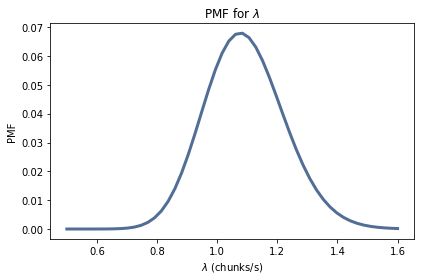

In [66]:
fileSize  = 12.91*1000; #MB
chunkSize = 4;
fileSize  = fileSize/chunkSize; #flie size in chunks

runtime   = 149*60; #s

data = pd.read_csv('torrent pieces.csv')          #wireshark dump
data = data[data.Info=="Piece[Malformed Packet]"] #this finds the piece packets 
times = np.array(data.Time);
times = times[45:] #dump the initial times, they aren't representitive
interTimes = np.diff(times)

lamPrior = np.linspace(0.5,1.6);

class Chunk(Suite):
    def Likelihood(self, inter, lam):
        return lam*exp(-lam*inter)
    
lamSuite = Chunk(lamPrior)
lamSuite.UpdateSet(interTimes)
thinkplot.Pdf(lamSuite)
thinkplot.decorate(title="PMF for $\lambda$",xlabel="$\lambda$ (chunks/s)",ylabel="PMF")

print(lamSuite.Mean())

Here's a histogram of the interarrival times:

![](interTimes.png)

That looks a bit exponential, so I'd say it was ok to model chunk arival as a poisson process.

For now let's do the forward problem, assuming that we know $\lambda$ (the mean download rate in chunks per second) exactly. This will help us find an easy optimization.

In [65]:
lam = lamSuite.Mean()
nChunks = ceil(fileSize);  #number of chunks in the file
sPerChunk = runtime/nChunks;  #how long each chunk takes to play

def PHaveChunkSlow(t):
    """
    Probability that we have a specific chunk by time t
    """
    pmf = MakePoissonPmf(lam*t,nChunks) #probabilities that have each number of chunks, 0-nChunks
    pHave = 0;
    for n,p in pmf.Items():
        pHave += (n/nChunks)*p
    return pHave

def PHaveChunk(t):
    n = min(lam*t,nChunks)
    return n/nChunks
    
ts = np.linspace(0,4000);
ps = [PHaveChunkSlow(t) for t in ts];
ps2 = [PHaveChunk(t) for t in ts];

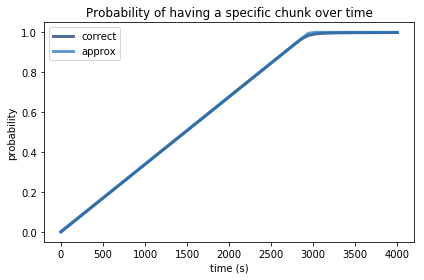

In [67]:
thinkplot.plot(ts,ps,label='correct')
thinkplot.plot(ts,ps2,label='approx')
thinkplot.decorate(title='Probability of having a specific chunk over time',
                  xlabel='time (s)',
                  ylabel='probability')

It looks like the native interpretation, where the probability of having a specific chunk at time t is

$$P=\frac{\min(\lambda t,N)}{N}$$

(where $N$ is the total number of chunks) is very close to the 'correct' implementation where

$$P=\sum_{n=0}^N \frac{n\cdot\text{poisson}(n;\lambda t)}{N}$$

but the approximate solution is much faster, so let's go with that.

Now we can predict how likely the priate is to be able to watch the movie uninterrupted.

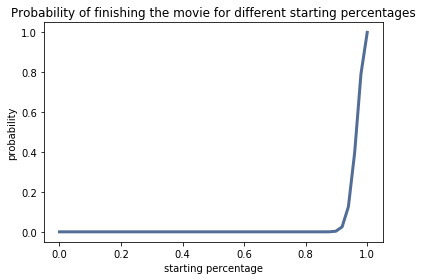

In [68]:
#we need a specific chunk every sPerChunk seconds to not break VLC
ts = np.linspace(0,runtime, ceil(runtime/sPerChunk)+1);

def PHaveChunk(x,t,lam):
    n0 = x*nChunks            #number of chunks at the begining
    n = min(lam*t+n0,nChunks) #number of chunks at time t
    return n/nChunks

def PSuccess(x,lam):
    """
    probability of getting all the way through the movie without missing a chunk
    having started watching at x percent downloaded
    """
    ps = [PHaveChunk(x, t, lam) for t in ts];
    return np.product(ps)

xs = np.linspace(0,1);
ps = [PSuccess(x,lam) for x in xs];

thinkplot.plot(xs,ps)
thinkplot.decorate(title='Probability of finishing the movie for different starting percentages',
                  xlabel='starting percentage',
                  ylabel='probability')

And we can now sum that over our $\lambda$ suite to find the real prediction:

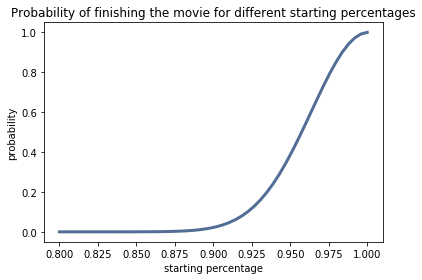

In [74]:
xs = np.linspace(0.8,1);
psTotal = np.zeros(len(xs));

for lam,p in lamSuite.Items():
    ps = [PSuccess(x,lam) for x in xs];
    psTotal += np.array(ps)*p
    
thinkplot.plot(xs,ps)
thinkplot.decorate(title='Probability of finishing the movie for different starting percentages',
                  xlabel='starting percentage',
                  ylabel='probability')

And would you look at that, nothing really changed. To answer the question, it looks like the pirate will have to wait until the movie is about 90% downloaded before they have any chance of finishing it, and they will have to wait until 95% downloaded to have a 50-50 shot.